# Imports

In [1]:
from collections import defaultdict

import hypertools as hyp
import numpy as np
import pandas as pd
from scipy.signal import resample
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

from khan_helpers import Experiment
from khan_helpers.constants import (
    BOS_LECTURE_COLOR,
    BOS_QUESTION_COLOR,
    FIG_DIR,
    FORCES_LECTURE_COLOR,
    FORCES_QUESTION_COLOR,
    GENERAL_QUESTION_COLOR,
    LECTURE_WSIZE,
    MODELS_DIR,
    RAW_DIR, 
    STOP_WORDS,
    TRAJS_DIR
)
from khan_helpers.functions import (
    _ts_to_sec,
    interp_lecture,
    multicol_display,
    parse_windows,
    preprocess_text,
    set_figure_style,
    show_source,
    synset_match
)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline

Experiment & Participant classes, helper functions, and variables used across multiple notebooks can be found in `/mnt/code/khan_helpers/khan_helpers`, or on GitHub, [here](https://github.com/contextlab/efficient-learning-khan/tree/master/code/khan_helpers).<br />You can also view source code directly from the notebook with:<br /><pre>    from khan_helpers.functions import show_source<br />    show_source(foo)</pre>

# Inspect some things defined in `khan_helpers`

In [2]:
show_source(Experiment)

In [3]:
show_source(preprocess_text)

In [4]:
show_source(synset_match)

In [5]:
show_source(parse_windows)

In [6]:
show_source(_ts_to_sec)

In [7]:
show_source(interp_lecture)

In [8]:
show_source(multicol_display)

In [9]:
show_source(set_figure_style)

In [10]:
show_source(show_source)

In [11]:
def get_top_words(cv, lda, n_words=10):
    topic_words = {}
    vocab = cv.get_feature_names_out()
    for topic, component in enumerate(lda.components_):
        word_ix = np.argsort(component)[::-1][:n_words]
        topic_words[topic] = [vocab[i] for i in word_ix]
    return topic_words

In [12]:
multicol_display(*sorted(STOP_WORDS), ncols=10, caption='Stop words')

a,about,above,actual,actually,after,again,against,ain,all
also,am,an,and,any,are,aren,aren't,as,at
be,because,been,before,being,below,between,bit,both,but
by,can,could,couldn,couldn't,d,did,didn,didn't,do
does,doesn,doesn't,doing,don,don't,down,during,e,each
even,few,first,follow,following,for,four,from,further,had
hadn,hadn't,has,hasn,hasn't,have,haven,haven't,having,he
her,here,hers,herself,him,himself,his,how,i,if
in,into,is,isn,isn't,it,it's,its,itself,just
let,like,ll,m,ma,mc,me,mightn,mightn't,more
most,mustn,mustn't,my,myself,needn,needn't,no,nor,not


# Inspect some of the raw data we're working with

In [13]:
exp = Experiment()
multicol_display(exp.forces_transcript[:334], 
                 exp.bos_transcript[:328], 
                 ncols=2, 
                 col_headers=['Four Fundamental Forces', 'Birth of Stars'],
                 cell_css={'text-align': 'left', 
                           'background-color': 'white', 
                           'padding-left': '10%'})

00:00.03what I want to do in this video is give00:01.829a very high-level overview of the four00:04.02fundamental forces four fundamental00:07.62forces of the universe and I'm going to00:09.54start with gravity I'm going to start00:12.719with gravity and it might surprise some00:15.57of you that gravity is actually the,00:00.03let's imagine we have a huge cloud of00:02.399hydrogen atoms floating in space Hugh00:05.67and I say huge cloud huge both in00:07.44distance and in mass if you were to00:09.69combine all of the hydrogen atoms it00:11.79would just be this really really massive00:14.549thing so you have this huge cloud well


In [14]:
exp.questions.head()

,lecture,question,A,B,C,D
index,,,,,,
1,1,Why is the gravitational attraction between yo...,Neither you nor your computer has enough mass ...,You and your computer are too close for the gr...,Humans are too small to detect the force of gr...,The gravitational attraction between you and y...
2,1,Which of the following is an example of the We...,A neutron in a radioactive Cesium atom is conv...,Light from the sun collides with a satellite o...,Two protons bound together in a Helium nucleus...,A distant galaxy exerts a small but detectable...
3,1,Roughly how many times stronger is the Weak In...,"10,000,000,000,000,000,000,000,000",10,"1,000,000",The Weak Interaction is less strong than gravity
4,1,Why don't you and your computer experience any...,The weak interaction only acts over extremely ...,The weak interaction between you and your comp...,You and your computer have no net charge,Neither you nor your computer has enough mass ...
5,1,Which of the following is a difference between...,Gravity is only ever attractive while the elec...,Gravity is a much more powerful force than ele...,Gravity can only act over large distances whil...,The electromagnetic force can only act over sm...


# Preprocess lecture, question, and answer text

In [15]:
forces_transcript = exp.forces_transcript
bos_transcript = exp.bos_transcript
questions = exp.questions

# make a few minor tweaks to the automatically generated lecture 
# transcripts -- fix some minor typos, combine prefixes with base word, 
# convert digits to words.
transcription_tweaks = {
    'cork': 'quark',
    'sub atomic': 'subatomic',
    'sub nucleic': 'subnucleic',
    'electro magnetic': 'electromagnetic',
    'electro static': 'electrostatic',
    'Ullom': 'coulomb',
    'cool': 'coulomb',
    'Hugh': 'huge',
    'hydrogen too': 'hydrogen two',
    ' eat': ' heat',
    ' cure ': ' core ',
    '10 ': 'ten ',
    '38 ': 'thirtyeight ',
    '38th ': 'thirtyeight ',
    '36 ': 'thirtysix',
    '25 ': 'twentyfive',
    '25th ': 'twentyfive'
}

for old, new in transcription_tweaks.items():
    forces_transcript = forces_transcript.replace(old, new)
    bos_transcript = bos_transcript.replace(old, new)

In [16]:
# convert digits to words in quiz answer text for model
questions.loc[3, ['A', 'B', 'C']] = ['ten to the twentyfive', 
                                     'ten', 
                                     'one million']
questions.loc[12, ['A', 'B', 'C']] = ['ten to the thirtyeight', 
                                      'one hundred', 
                                      'ten to the eighteen']
questions.loc[18, ['A', 'B', 'C', 'D']] = ['ten million kelvin', 
                                           'zero kelvin', 
                                           'ten thousand kelvin', 
                                           'ten billion kelvin']
questions.loc[37, ['A', 'B', 'C', 'D']] = ['less than one percent', 
                                           'ten percent', 
                                           'fifty percent', 
                                           'more than ninety percent']

In [17]:
# keep track of lemmatizations performed via WordNet workaround to 
# spot-check below (see preprocess_text docstring)
lemma_counter = defaultdict(int)

In [18]:
ff_lines = forces_transcript.splitlines()
ff_timestamps = ff_lines[::2]
ff_text_lines = ff_lines[1::2]
ff_lines_processed = preprocess_text(ff_text_lines, 
                                     correction_counter=lemma_counter)

ff_transcript_processed = []
for ts_line, txt_line in zip(ff_timestamps, ff_lines_processed):
    ff_transcript_processed.append(f'{ts_line}\n{txt_line}')
ff_transcript_processed = '\n'.join(ff_transcript_processed)

In [19]:
bos_lines = bos_transcript.splitlines()
bos_timestamps = bos_lines[::2]
bos_text_lines = bos_lines[1::2]
bos_lines_processed = preprocess_text(bos_text_lines, 
                                      correction_counter=lemma_counter)

bos_transcript_processed = []
for ts_line, txt_line in zip(bos_timestamps, bos_lines_processed):
    bos_transcript_processed.append(f'{ts_line}\n{txt_line}')
bos_transcript_processed = '\n'.join(bos_transcript_processed)

In [20]:
quiz_text = questions.values[:, 1:]
quiz_text_processed = preprocess_text(quiz_text.ravel(), 
                                      correction_counter=lemma_counter)
quiz_text_processed = np.reshape(quiz_text_processed, quiz_text.shape)
question_text = quiz_text_processed[:, 0]
correct_answer_text = quiz_text_processed[:, 1]

In [21]:
# check to ensure all changes make sense
multicol_display(*np.ravel([(k[0], k[1], v) for k, v in lemma_counter.items()]),
                 ncols=6,
                 caption="Synset-based lemmatizations",
                 col_headers=('Word', 'Lemma', 'Count', 'Word', 'Lemma', 'Count'))

surprising,surprise,2,exactly,exact,1
essentially,essential,2,completely,complete,1
applies,apply,1,disappears,disappear,1
operating,operate,1,atoms,atom,1
slowly,slow,6,denser,dense,8
condensing,condense,1,interesting,interest,1
happens,happen,1,obviously,obvious,2
positively,positive,2,slightly,slight,2
degrades,degrade,1,combined,combine,5
occurs,occur,3,eventually,eventual,2
fused,fuse,1,collides,collide,1


# Parse lecture transcripts into overlapping sliding windows

In [22]:
forces_windows, forces_timestamps = parse_windows(ff_transcript_processed, 
                                                  LECTURE_WSIZE)
bos_windows, bos_timestamps = parse_windows(bos_transcript_processed, 
                                            LECTURE_WSIZE)

# Fit model & transform lectures, questions, and answers

In [23]:
N_TOPICS = 15

# create corpus from both lectures' sliding windows
corpus = np.concatenate((forces_windows, 
                         bos_windows))

# fit CountVectorizer and LatentDirichletAllocation models to full corpus
cv = CountVectorizer()
lda = LatentDirichletAllocation(n_components=N_TOPICS, random_state=0)
lda.fit(cv.fit_transform(corpus))


# transform lecture windows
forces_traj = lda.transform(cv.transform(forces_windows))
bos_traj = lda.transform(cv.transform(bos_windows))

# transform questions
all_questions = lda.transform(cv.transform(question_text))

# transform answers
all_answers = lda.transform(cv.transform(quiz_text_processed[:, 1:].ravel()))
all_answers = all_answers.reshape(39, 4, 15)

# interpolate lecture trajectories to 1 topic vector per second
forces_traj = interp_lecture(forces_traj, forces_timestamps)
bos_traj = interp_lecture(bos_traj, bos_timestamps)

# Inspect the topics our model identified

In [24]:
topic_words = get_top_words(cv, lda)
for topic, words in topic_words.items():
    print(f'topic {topic + 1}:\n\t{", ".join(words)}')

topic 1:
	star, helium, main, mass, atomic, sequence, get, energy, fuse, hydrogen
topic 2:
	charge, force, mass, gravity, strong, attract, large, strength, distance, electromagnetic
topic 3:
	huge, force, electromagnetic, macro, way, scale, concentration, apply, kind, charge
topic 4:
	atom, dense, go, hydrogen, slow, get, huge, condense, mass, would
topic 5:
	fusion, get, threshold, core, occur, mass, something, start, several, jupiter
topic 6:
	enough, ignition, proton, force, get, close, nucleus, coulomb, fusion, would
topic 7:
	energy, pressure, ignition, mass, little, keep, provide, fusion, get, hydrogen
topic 8:
	proton, weak, neutron, interaction, one, go, nucleon, cesium, extra, get
topic 9:
	run, kind, say, go, want, would, get, well, give, although
topic 10:
	huge, cloud, space, float, imagine, hydrogen, atom, say, distance, combine
topic 11:
	one, hydrogen, helium, go, proton, neutron, keep, atomic, detail, fuse
topic 12:
	gravity, force, weak, interaction, apply, strength, d

# Active topics figure

In [25]:
forces_questions = all_questions[np.flatnonzero(questions['lecture'] == 1)]
bos_questions = all_questions[np.flatnonzero(questions['lecture'] == 2)]
general_questions = all_questions[np.flatnonzero(questions['lecture'] == 0)]

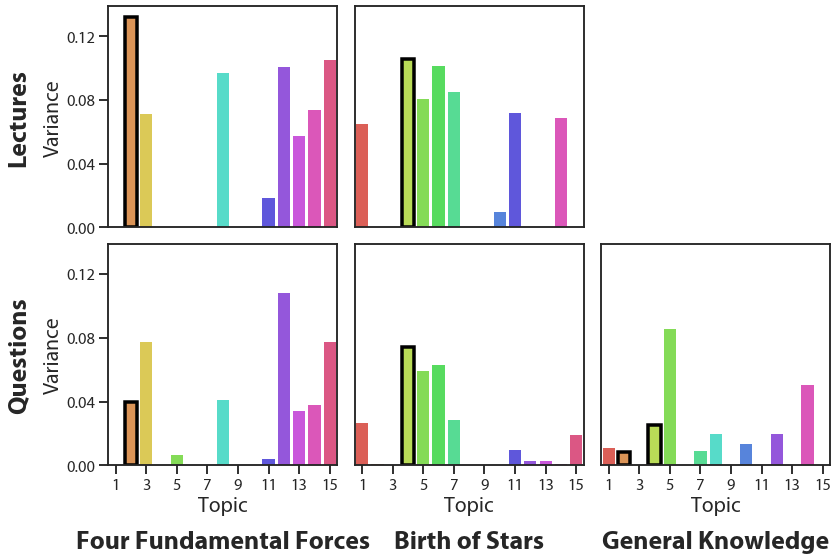

In [26]:
with sns.axes_style('ticks'), sns.plotting_context('talk'):
    set_figure_style()
    palette = sns.color_palette('hls', N_TOPICS)

    fig, axarr = plt.subplots(2, 3, sharex=True, sharey='all')
    fig.set_size_inches(12, 8)
    axarr = axarr.flatten()

    for i, traj in enumerate([forces_traj, 
                              bos_traj, 
                              None,
                              forces_questions,
                              bos_questions,
                              general_questions]):
        ax = axarr[i]
        if traj is None:
            ax.axis('off')
            continue

        topic_vars = np.var(traj, axis=0)
        bars = ax.bar(x=list(range(1, N_TOPICS + 1)), 
                      height=topic_vars, 
                      color=palette, edgecolor='none')
        ax.set_xlim(.5, N_TOPICS + 0.5)
        ax.set_xticks(list(range(1, N_TOPICS + 1, 2)))
        
        if i == 0:
            ax.set_ylabel('Variance', fontsize='large')
            ax.annotate('Lectures', 
                        xy=(-.7, .5), 
                        xycoords=ax.yaxis.label, 
                        size='x-large', 
                        rotation=90, 
                        ha='right', 
                        va='center', 
                        fontweight='bold')
        elif i == 3:
            ax.set_title('Four Fundamental Forces', 
                         fontsize='x-large', 
                         y=-0.4, 
                         fontweight='bold')
            ax.set_ylabel('Variance', fontsize='large')
            ax.annotate('Questions', 
                        xy=(-.7, .5), 
                        xycoords=ax.yaxis.label, 
                        size='x-large', 
                        rotation=90, 
                        ha='right', 
                        va='center', 
                        fontweight='bold')
        elif i == 4:
            ax.set_title('Birth of Stars', 
                         fontsize='x-large', 
                         y=-0.4, 
                         fontweight='bold')
        elif i == 5:
            ax.set_title('General Knowledge', 
                         fontsize='x-large', 
                         y=-0.4, 
                         fontweight='bold')

        if i > 2:
            ax.set_xlabel('Topic', fontsize='large')
            
        if i in (0, 3):
            ax.set_yticks(np.arange(0, ax.get_ylim()[1], 0.04))
        else:
            ax.tick_params(axis='y', length=0)
        if i < 3:
            ax.tick_params(axis='x', length=0)
            
        if i in (0, 3, 5):
            ax.patches[1].set_edgecolor('black')
            ax.patches[1].set_linewidth(3.5)
        if i in (1, 4, 5):
            ax.patches[3].set_edgecolor('black')
            ax.patches[3].set_linewidth(3.5)


    plt.tight_layout()
    plt.subplots_adjust(hspace=0.075, wspace=0.075)
#     plt.savefig(FIG_DIR.joinpath('active-topics.pdf'), bbox_inches='tight')
    plt.show()

# 3D trajectories figure

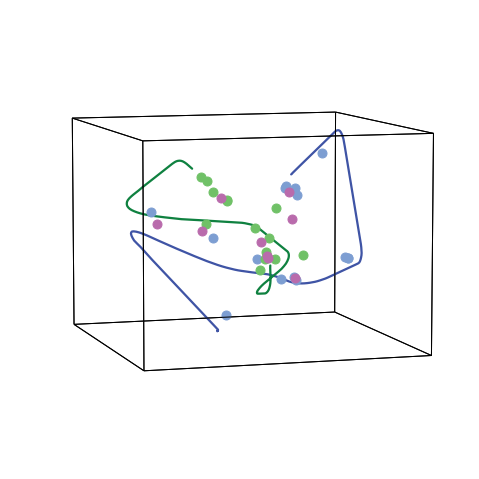

In [27]:
# resample trajectories to common length and smooth for visualization
bos_traj_resampled = resample(bos_traj, 200, axis=0)
forces_traj_resampled = resample(forces_traj, 200, axis=0)

forces_smoothed = pd.DataFrame(forces_traj_resampled).rolling(24).mean().loc[24:, :].values
bos_smoothed = pd.DataFrame(bos_traj_resampled).rolling(24).mean().loc[24:, :].values

forces_questions = all_questions[np.flatnonzero(questions['lecture'] == 1)]
bos_questions = all_questions[np.flatnonzero(questions['lecture'] == 2)]
general_questions = all_questions[np.flatnonzero(questions['lecture'] == 0)]

with sns.plotting_context('talk'):
    hyp.plot([forces_smoothed, 
              bos_smoothed, 
              forces_questions, 
              bos_questions, 
              general_questions], 
             fmt=['-', '-', 'o', 'o', 'o'],
             color=[FORCES_LECTURE_COLOR, 
                    BOS_LECTURE_COLOR, 
                    FORCES_QUESTION_COLOR, 
                    BOS_QUESTION_COLOR, 
                    GENERAL_QUESTION_COLOR],
             reduce={'model': 'IncrementalPCA', 'params': {'whiten': True}}, 
#                  save_path=FIG_DIR.joinpath('trajectories-3d.pdf'),
             size=[7, 7], 
             azim=73, 
             elev=7)

## Save data and fit models

In [28]:
# np.save(TRAJS_DIR.joinpath('forces_lecture'), forces_traj)
# np.save(TRAJS_DIR.joinpath('bos_lecture'), bos_traj)
# np.save(TRAJS_DIR.joinpath('all_questions'), all_questions)
# np.save(TRAJS_DIR.joinpath('all_answers'), all_answers)
# np.save(RAW_DIR.joinpath('forces_windows'), forces_windows)
# np.save(RAW_DIR.joinpath('bos_windows'), bos_windows)
# np.save(RAW_DIR.joinpath('forces_timestamps'), forces_timestamps)
# np.save(RAW_DIR.joinpath('bos_timestamps'), bos_timestamps)
# np.save(RAW_DIR.joinpath('quiz_text_processed'), quiz_text_processed)
# np.save(MODELS_DIR.joinpath('fit_CV'), cv)
# np.save(MODELS_DIR.joinpath('fit_LDA'), lda)